In [1]:
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from matplotlib import pyplot as plt

from grid_manager import MPC_op
from data_loader import UCSD_dataloader
from battery_model import Battery_base
from optimizer import Battery_optimizer
from predictor import *
from utils.plot_utils import *

customize_plt()

In [2]:
# 参数设定

a1=np.array([-20/4]*4)
a2=np.array([20/4]*4)
a3=np.array([-40/4]*4)
a4=np.array([40/4]*4)
a5=np.array([-60/4]*4)
a6=np.array([60/4]*4)
a7=np.array([-80/4]*4)
a8=np.array([80/4]*4)


# 充电循环设置（目前对比结果中p1、p2、p6效果较好）
p1=np.array([4]*72)

p2=-np.concatenate((a1,a2,a1,a2,a3,a4,a3,a4,a5,a6,a5,a6))*4
# p2=-np.concatenate((a1/1.1,a2/1.1,a1/1.1,a2/1.1,a3/1.1,a4/1.1,a3/1.1,a4/1.1,a5/1.1,a6/1.1,a5/1.1,a6/1.1))*4

p3=-np.concatenate((a1,a2,a7,a2,a1,a8,a1,a2,a1,a2,a7,a8))*4

# p4、p5为将p3拆分
p4=-np.concatenate((a1,a2,a7,a2,a1,a8))*4
p5=-np.concatenate((a1,a2,a1,a2,a7,a8))*4

p6=-np.concatenate((a1/2,a2/2,a7,a2/2,a1/2,a8,a1/2,a2/2,a1/2,a2/2,a7,a8))*4

e_init1=90
e_init2=90
e_init3=90


bat_params_sample ={
    "bat_capacity": 100,
    "bat_p_max": 1, # i.e., capacity (kWh) / p_bat_max (kW) = 3 (h)
    "bat_p_min": 1, # can omit, then p_bat_min = p_bat_max
    "bat_price": 150, # $/kWh (old: 1000, ref: Tesla Powerwall)
    "bat_efficacy": 1, 
    "bat_life_0": 3650, # days.
    "bat_cycle_0": 3000, # cycles in lifetime
    # battery degradation params
    "deg_model": "DOD",  
        # valid values: "throughput", "Crate", "rainflow", "DOD"
    #   [1. degradation ~ high C-rate]
    "deg_Crate_thres": (0.25, 0.25, 0.25, 0.25),
    "deg_Crate_lambda": (0.8, 1, 1.2, 1.5),
    #   [2. degradation ~ large cycle depth]
    "deg_rainflow_thres": (0.2, 0.2, 0.2, 0.4),
    "deg_rainflow_lambda": (0.6, 1, 1.5, 1.8),
    #   [3. degradation ~ low SoE range]
    "deg_DOD_thres": (0.5, 0.2, 0.2, 0.1),
    "deg_DOD_lambda": (1.3, 1.15, 0.85, 0.6),
}


In [17]:
deg_list = ["throughput", "Crate", "rainflow", "DOD"]
deg_names = {"throughput": "throughput",
              "Crate": "C-rate",
              "rainflow": "rainflow - cycle depth",
              "DOD": "state of energy"}
colors = {
    "throughput":"silver",
    "Crate":"hotpink",
    "rainflow":"limegreen",
    "DOD":"slateblue",
}

In [29]:
def cycle_new(p,e_init,bat_params_sample,dt=4, axs=None, incl=(0,1,2,3)): # p为充电量、e_init为初始电量、dt为rainflow计算时取等效循环时间步长（除p1都取4）

    # 参数计算及获取
    b_sample = Battery_base(bat_params_sample)
    b_sample.update_soc(p=p,e_init=e_init)
    
    cycle_history = b_sample.cycle_history
    for k in cycle_history:
        cycle_history[k] = np.array(cycle_history[k])

    # 计算以4为步长的平均等效循环次数（目前仅算rainflow)
    key = "rainflow"
    cycle_history[key] = np.repeat(np.mean(cycle_history[key].reshape(-1,dt),axis=1),dt)
    # DOD = np.repeat(np.mean(np.array(DOD).reshape(-1,4),axis=1),4).tolist()

    # 计算lambda
    # FIXME: if p = 0, then throughput cycles = 0, divided by 0 error !
    lambda_history = {}
    ref = cycle_history["throughput"]
    for key in deg_list:
        lambda_history[key] = cycle_history[key] / ref

    #画图
    if axs is None:
        figs,axs=plt.subplots(len(incl),1, figsize=(8,8))

    idx = 0

    if 0 in incl:
        # 充电功率
        axs[idx].plot(p,label='p')
        idx += 1

    if 1 in incl:
        # 电池容量
        e = -np.cumsum(p)/4+e_init
        soc = e / b_sample.get_params("bat_capacity")
        axs[idx].plot(soc,label='e', color="slategrey")
        idx += 1
    
    if 2 in incl:
        #lambda
        for key in deg_list:
            axs[idx].plot(lambda_history[key],label=deg_names[key], c=colors[key])
        idx += 1
    
    if 3 in incl:
        # 等效累计循环
        for key in deg_list:
            axs[idx].plot(cycle_history[key].cumsum(),label=deg_names[key], c=colors[key])
        idx += 1

    

    return axs

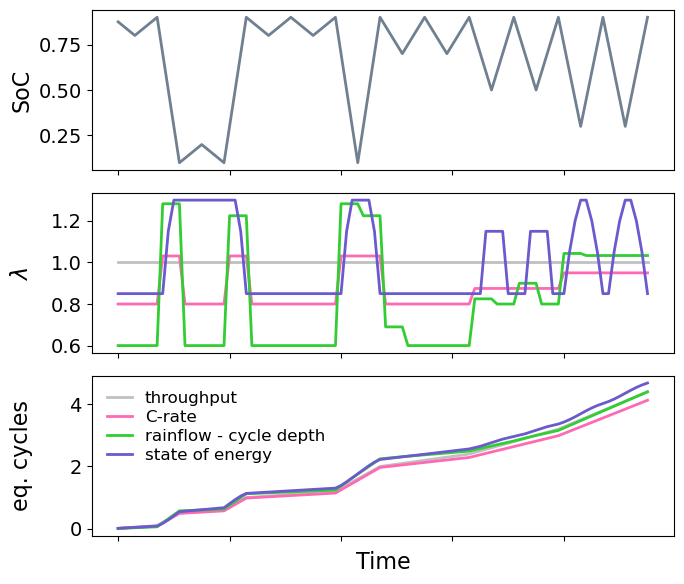

In [31]:
fig, axs= plt.subplots(3, 1, figsize=(7, 6))
cycle_new(p=np.hstack([p6, p2]),e_init=e_init2,bat_params_sample=bat_params_sample,dt=4, axs=axs, incl=(1,2,3))
axs[2].legend(loc="upper left", handlelength=1.5)

ylables = [
    "SoC", r'$\lambda$', "eq. cycles"
]

for i in range(3):
    ax = axs[i]
    ax.set_xticklabels([])
    ax.set_ylabel(ylables[i])
    if i == 2:
        ax.set_xlabel("Time")
fig.align_ylabels(axs)
plt.tight_layout()

# plt.savefig("214-fig2-cycle_demo.png", dpi=300, facecolor="w", bbox_inches="tight")

In [ ]:
def cycle(p,e_init,bat_params_sample,dt=4, axs=None): # p为充电量、e_init为初始电量、dt为rainflow计算时取等效循环时间步长（除p1都取4）

    # 参数计算及获取
    b_sample = Battery_base(bat_params_sample)
    b_sample.update_soc(p=p,e_init=e_init)
    
    throughput = b_sample.cycle_history['throughput']
    Crate = b_sample.cycle_history['Crate']
    rainflow = b_sample.cycle_history['rainflow']
    DOD = b_sample.cycle_history['DOD']

    # 计算以4为步长的平均等效循环次数（目前仅算rainflow)
    rainflow = np.repeat(np.mean(np.array(rainflow).reshape(-1,dt),axis=1),dt).tolist()
    # DOD = np.repeat(np.mean(np.array(DOD).reshape(-1,4),axis=1),4).tolist()

    # 计算lambda
    # FIXME: if p = 0, then throughput cycles = 0, divided by 0 error !
    Crate_norm = [x/y for x,y in zip(Crate,throughput)]
    rainflow_norm = [x/y for x,y in zip(rainflow,throughput)]
    DOD_norm = [x/y for x,y in zip(DOD,throughput)]
    throughput_norm = [x/y for x,y in zip(throughput,throughput)]

    #画图
    if axs is None:
        figs,axs=plt.subplots(4,1, figsize=(8,8))


    # 充电功率
    axs[0].plot(p,label='p')
    axs[0].legend(bbox_to_anchor=(1.15,0.45))
    # ax[0].set_title('p')

    # 电池容量
    axs[1].plot(-np.cumsum(p)/4+e_init,label='e')
    axs[1].legend(bbox_to_anchor=(1,0.45))
    # ax[1].set_title('e')

    # 等效循环
    axs[2].plot(throughput,label='throughput')
    axs[2].plot(Crate,label='Crate')
    axs[2].plot(rainflow,label='rainflow')
    axs[2].plot(DOD,label='DOD')
    # ax[2].set_title('number of cycle(time)')

    axs[2].legend(bbox_to_anchor=(1.25,0.45))

    #lambda
    axs[3].plot(throughput_norm,label='throughput')
    axs[3].plot(Crate_norm,label='Crate')
    axs[3].plot(rainflow_norm,label='rainflow')
    axs[3].plot(DOD_norm,label='DOD')
    # ax[3].set_title('lambda')

    axs[3].legend(bbox_to_anchor=(1.25,0.45))

    return 0

0

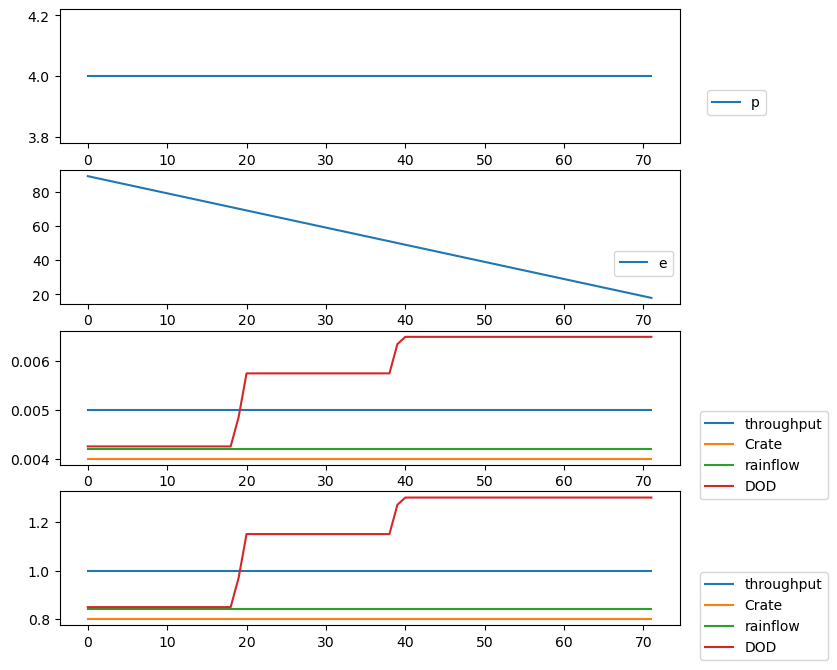

In [37]:
cycle(p=p1,e_init=e_init1,bat_params_sample=bat_params_sample,dt=72)

0

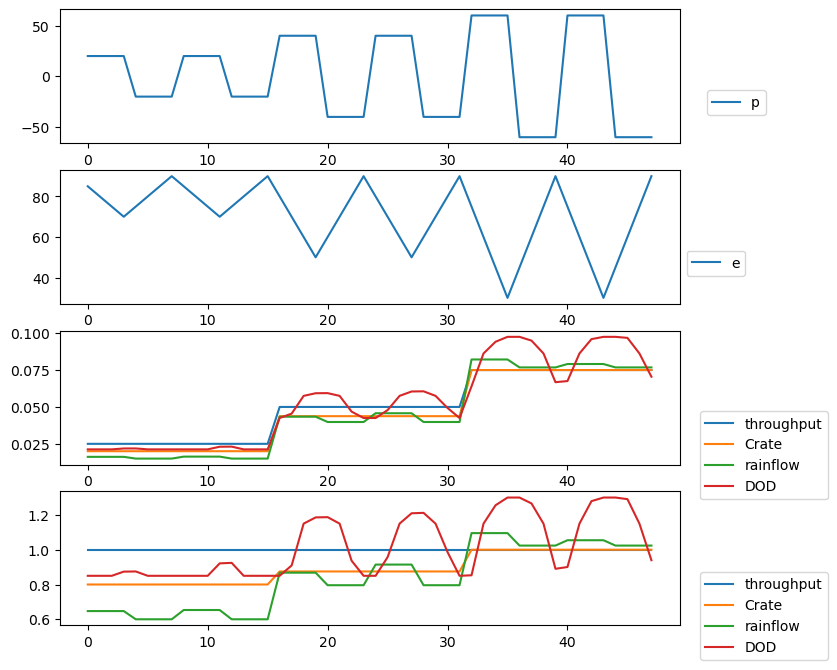

In [7]:
cycle(p=p2,e_init=e_init2,bat_params_sample=bat_params_sample)

0

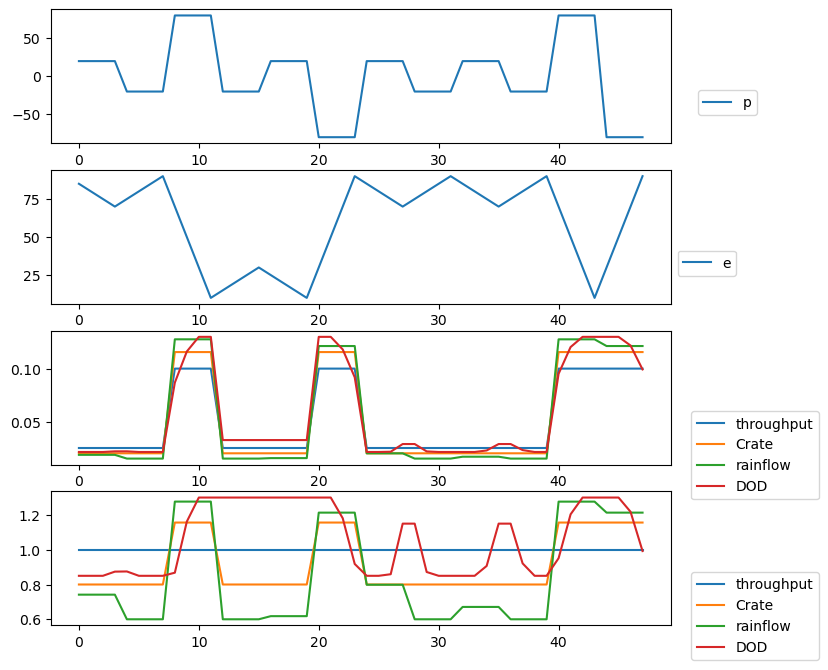

In [31]:
cycle(p=p3,e_init=e_init2,bat_params_sample=bat_params_sample)

0

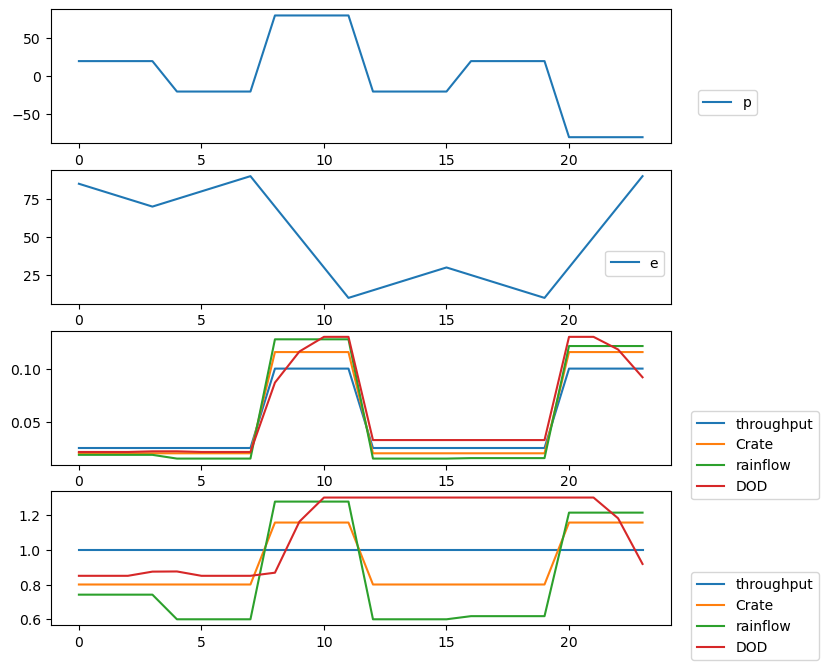

In [42]:
cycle(p=p4,e_init=e_init2,bat_params_sample=bat_params_sample)

0

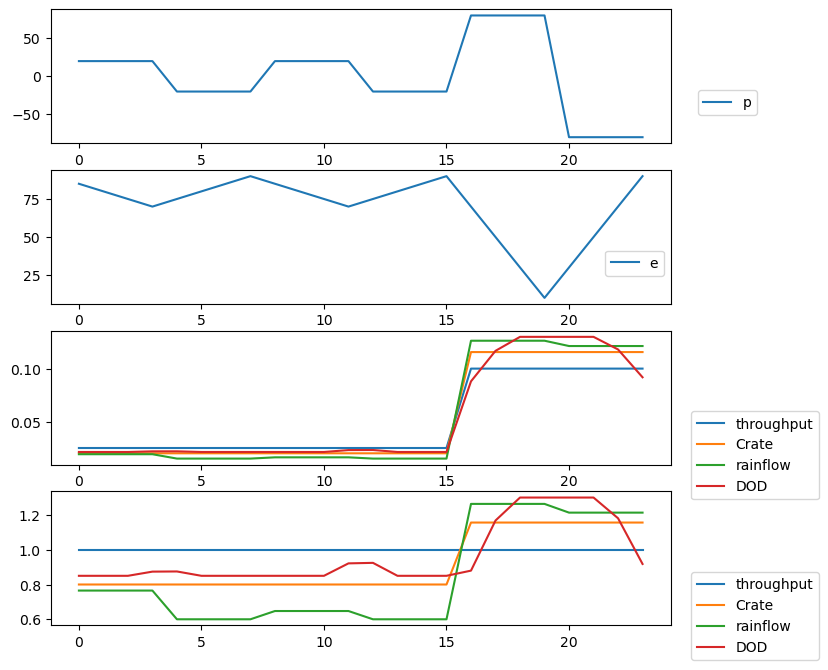

In [43]:
cycle(p=p5,e_init=e_init2,bat_params_sample=bat_params_sample)

0

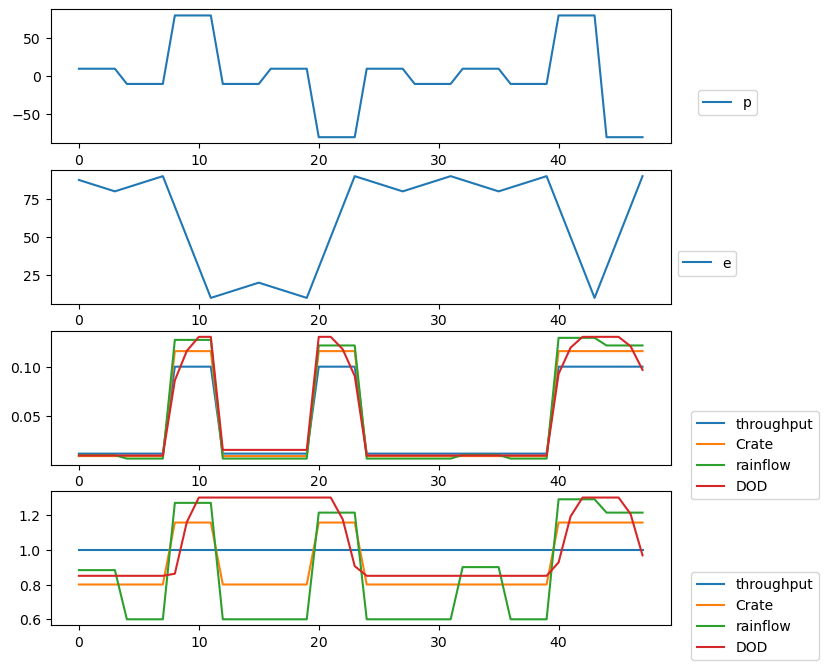

In [47]:
cycle(p=p6,e_init=e_init2,bat_params_sample=bat_params_sample)

## 未整理

In [20]:
throughput = b_sample.cycle_history['throughput']
Crate = b_sample.cycle_history['Crate']
rainflow = b_sample.cycle_history['rainflow']
DOD = b_sample.cycle_history['DOD']

dt=4  # 计算以4为步长的平均等效循环次数
rainflow = np.repeat(np.mean(np.array(rainflow).reshape(-1,dt),axis=1),dt).tolist()
# DOD = np.repeat(np.mean(np.array(DOD).reshape(-1,4),axis=1),4).tolist()


Crate_norm = [x/y for x,y in zip(Crate,throughput)]
rainflow_norm = [x/y for x,y in zip(rainflow,throughput)]
DOD_norm = [x/y for x,y in zip(DOD,throughput)]
throughput_norm = [x/y for x,y in zip(throughput,throughput)]


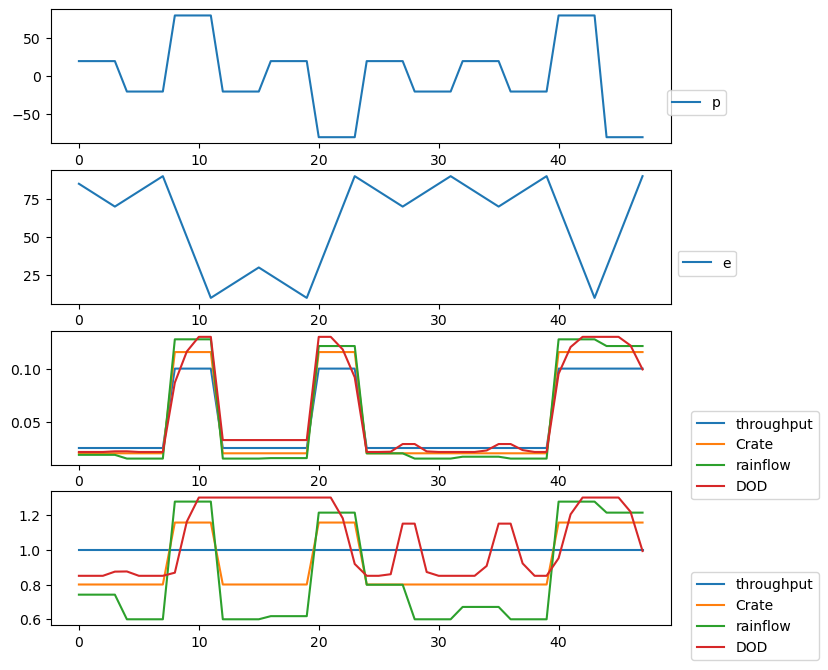

In [21]:
fig,ax=plt.subplots(4,1)

fig.set_size_inches(8,8)


ax[0].plot(p,label='p')
ax[0].legend(bbox_to_anchor=(1.1,0.45))
# ax[0].set_title('p')

ax[1].plot(-np.cumsum(p)/4+e_init,label='e')
ax[1].legend(bbox_to_anchor=(1,0.45))
# ax[1].set_title('e')

ax[2].plot(throughput,label='throughput')
ax[2].plot(Crate,label='Crate')
ax[2].plot(rainflow,label='rainflow')
ax[2].plot(DOD,label='DOD')
# ax[2].set_title('number of cycle(time)')

ax[2].legend(bbox_to_anchor=(1.25,0.45))

ax[3].plot(throughput_norm,label='throughput')
ax[3].plot(Crate_norm,label='Crate')
ax[3].plot(rainflow_norm,label='rainflow')
ax[3].plot(DOD_norm,label='DOD')
# ax[3].set_title('lambda')

ax[3].legend(bbox_to_anchor=(1.25,0.45))